In [8]:
from PIL import Image, ImageOps
from sklearn.decomposition import PCA
import numpy as np
import os
import matplotlib.pyplot as plt


In [9]:
def img_data(img_path, disp=True):
    # Open the image file
    orig_img = Image.open(img_path)
    
    # Get the size of the image in kilobytes
    img_size_kb = os.stat(img_path).st_size / 1024
    
    # Get image data and reshape to a numpy array
    data = orig_img.getdata()
    ori_pixels = np.array(data).reshape(*orig_img.size, -1)
    
    # Get the dimensions of the image
    img_dim = ori_pixels.shape
    
    # Display the image if requested
    if disp:
        plt.imshow(orig_img)
        plt.axis('off')  # Hide axes
        plt.show()
    
    # Create a dictionary with image size and dimensions
    data_dict = {
        'img_size_kb': img_size_kb,
        'img_dim': img_dim
    }
    
    return data_dict


In [10]:
def pca_compose(imgPath):
    orig_img = Image.open(imgPath)
    
    # Convert the image into a 3D numpy array (height, width, channels)
    img = np.array(orig_img)
    
    # Separate channels from image and use PCA on each channel
    pca_channel = {}
    
    for i in range(img.shape[-1]):  # For each RGB channel compute the PCA
        channel = img[:, :, i]  # Extract channel i (2D array)

        pca = PCA(random_state=42)  # Initialize PCA
        fit_pca = pca.fit_transform(channel)  # Fit PCA

        pca_channel[i] = (pca, fit_pca)  # Save PCA models for each channel

    return pca_channel


In [11]:
def pca_transform(pca_channel, n_components):
    temp_res = []
    for channel in range(len(pca_channel)):
        pca, fit_pca = pca_channel[channel]
        pca_pixel = fit_pca[:, :n_components]
        pca_comp = pca.components_[:n_components, :]
        compressed_pixel = np.dot(pca_pixel, pca_comp) + pca.mean_
        temp_res.append(compressed_pixel)
    
    # Combine channels back into a single image
    compressed_image = np.stack(temp_res, axis=-1)
    compressed_image = np.array(compressed_image, dtype=np.uint8)
    return compressed_image

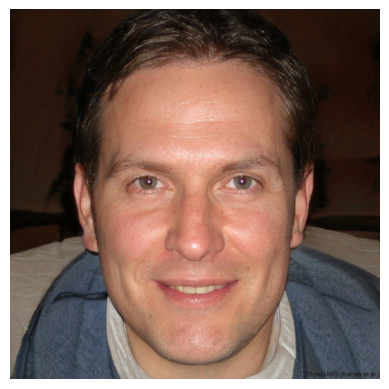

Image Size: 587.95 KB
Image Dimensions: (1024, 1024, 3)


In [12]:
image_info = img_data('img.jpg', disp=True)

# Print the results
print(f"Image Size: {image_info['img_size_kb']:.2f} KB")
print(f"Image Dimensions: {image_info['img_dim']}")


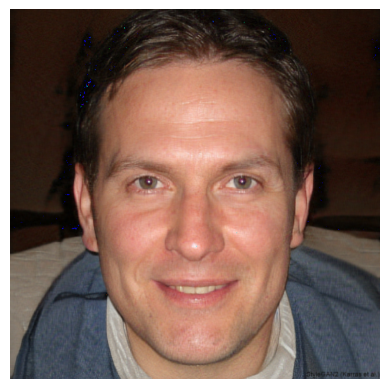

Compressed Image Dimensions: (1024, 1024, 3)


In [17]:
pca_channel = pca_compose('img.jpg')
compressed = pca_transform(pca_channel, 100)  # Increased components to 100

# Display the compressed image
plt.imshow(compressed)
plt.axis('off')
plt.show()

# Optionally, save the compressed image
compressed_img = Image.fromarray(compressed)
compressed_img.save('compressed_img.jpg')

# Print compressed image dimensions
print(f"Compressed Image Dimensions: {compressed.shape}")

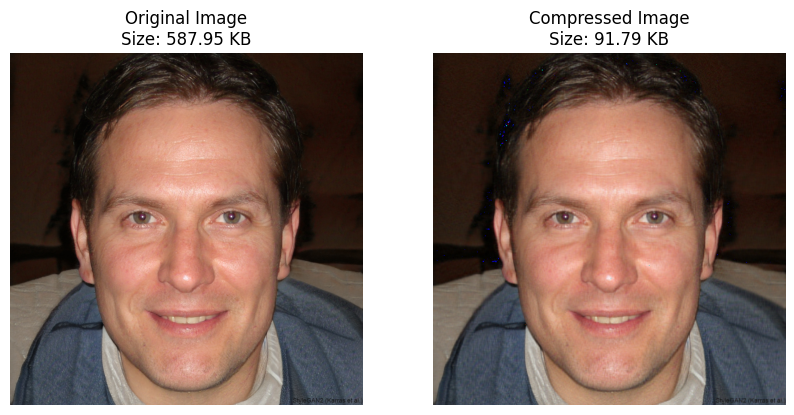

In [18]:
def compare_images(original_img_path, compressed_img):
    # Load the original image
    orig_img = Image.open(original_img_path)
    
    # Calculate original image size
    orig_img_size_kb = os.stat(original_img_path).st_size / 1024
    
    # Calculate compressed image size by saving temporarily and measuring file size
    compressed_img_path = 'compressed_temp.jpg'
    compressed_img = Image.fromarray(compressed_img)
    compressed_img.save(compressed_img_path)
    compressed_img_size_kb = os.stat(compressed_img_path).st_size / 1024
    
    # Display both images side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Original image
    axs[0].imshow(orig_img)
    axs[0].set_title(f"Original Image\nSize: {orig_img_size_kb:.2f} KB")
    axs[0].axis('off')
    
    # Compressed image
    axs[1].imshow(compressed_img)
    axs[1].set_title(f"Compressed Image\nSize: {compressed_img_size_kb:.2f} KB")
    axs[1].axis('off')
    
    plt.show()
    
    # Clean up the temporary file
    os.remove(compressed_img_path)

# Call the comparison function
compare_images('img.jpg', compressed)